# import library

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')


plt.rcParams['font.family'] = 'Malgun Gothic'

# load data

In [2]:
inpo_df = pd.read_csv('preprocessed data/interpolation_df.csv', index_col=0)
info_df = inpo_df.loc[:,:'INCOME']
info_df

,SEX,AGE,AREA,INCOME
2,F,50대,서울특별시,300만원 미만
15,F,30대,서울특별시,500이상700만원 미만
16,F,30대,서울특별시,500이상700만원 미만
41,M,20대,서울특별시,300이상500만원 미만
42,M,20대,서울특별시,500이상700만원 미만
...,...,...,...,...
19304,F,50대,서울특별시,300이상500만원 미만
19317,F,30대,서울특별시,500이상700만원 미만
19365,M,20대,서울특별시,300만원 미만
19400,F,60대,서울특별시,300만원 미만


# onehotvector encoding

In [3]:
def encoding(*cols):
    df_encoded = info_df.copy()
    for index, col in enumerate(cols):
        encoder = OneHotEncoder(sparse_output=False)
        onehot = encoder.fit_transform(info_df[[col]])
        # index를 info_df와 맞춰서 생성
        onehot_df = pd.DataFrame(
            onehot,
            columns=encoder.get_feature_names_out([col]),
            index=info_df.index
        )
        df_encoded = pd.concat([df_encoded, onehot_df], axis=1)
    return df_encoded


In [4]:
df_encoded = encoding('SEX', 'AGE', 'AREA', 'INCOME')
df_encoded.drop(['SEX', 'AGE', 'AREA', 'INCOME'], axis=1,inplace=True)
df_encoded

,SEX_F,SEX_M,AGE_20대,AGE_30대,AGE_40대,AGE_50대,AGE_60대,AREA_서울특별시,INCOME_300만원 미만,INCOME_300이상500만원 미만,INCOME_500이상700만원 미만
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
15,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
16,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
41,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
42,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
19304,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
19317,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
19365,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
19400,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [8]:
# 다양한 주성분 수에 대해 KMeans 클러스터링 수행
components_range = range(2, 11)  # 2에서 10까지의 주성분 수
results = {}
X=np.array(df_encoded.dropna())

for n_components in components_range:
    # PCA 적용
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # 분산 비율 확인
    print(f"\n주성분 수: {n_components}")
    print("주성분의 분산 비율:", pca.explained_variance_ratio_)
    
    # 주성분의 누적 분산 비율 확인
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    print("누적 분산 비율:", cumulative_variance)

    # 클러스터 수 범위 설정
    k_values = range(1, 10)  # 1부터 9까지의 클러스터 수

    sse = []  # SSE 값을 저장할 리스트
    silhouette_scores = []  # 실루엣 점수를 저장할 리스트

    # 클러스터 수에 따른 KMeans 모델 학습 및 평가
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_pca)
        
        # SSE 저장
        sse.append(kmeans.inertia_)
        
        # 실루엣 점수 계산
        if k > 1:  # 클러스터 수가 1보다 클 때만 계산
            silhouette_avg = silhouette_score(X_pca, kmeans.labels_)
            silhouette_scores.append(silhouette_avg)
            print(f'클러스터 수: {k}, 실루엣 점수: {silhouette_avg:.2f}')
        else:
            silhouette_scores.append(None)  # 클러스터 수가 1일 때는 None

    # 결과 저장
    results[n_components] = {
        "SSE": sse,
        "Silhouette Scores": silhouette_scores
    }



주성분 수: 2
주성분의 분산 비율: [0.26531156 0.20176577]
누적 분산 비율: [0.26531156 0.46707733]
클러스터 수: 2, 실루엣 점수: 0.57
클러스터 수: 3, 실루엣 점수: 0.64
클러스터 수: 4, 실루엣 점수: 0.78
클러스터 수: 5, 실루엣 점수: 0.84
클러스터 수: 6, 실루엣 점수: 0.88
클러스터 수: 7, 실루엣 점수: 0.85
클러스터 수: 8, 실루엣 점수: 0.79
클러스터 수: 9, 실루엣 점수: 0.77

주성분 수: 3
주성분의 분산 비율: [0.26531156 0.20176577 0.14011884]
누적 분산 비율: [0.26531156 0.46707733 0.60719618]
클러스터 수: 2, 실루엣 점수: 0.44
클러스터 수: 3, 실루엣 점수: 0.46
클러스터 수: 4, 실루엣 점수: 0.54
클러스터 수: 5, 실루엣 점수: 0.60
클러스터 수: 6, 실루엣 점수: 0.64
클러스터 수: 7, 실루엣 점수: 0.68
클러스터 수: 8, 실루엣 점수: 0.73
클러스터 수: 9, 실루엣 점수: 0.78

주성분 수: 4
주성분의 분산 비율: [0.26531156 0.20176577 0.14011884 0.12689875]
누적 분산 비율: [0.26531156 0.46707733 0.60719618 0.73409493]
클러스터 수: 2, 실루엣 점수: 0.37
클러스터 수: 3, 실루엣 점수: 0.39
클러스터 수: 4, 실루엣 점수: 0.47
클러스터 수: 5, 실루엣 점수: 0.56
클러스터 수: 6, 실루엣 점수: 0.59
클러스터 수: 7, 실루엣 점수: 0.63
클러스터 수: 8, 실루엣 점수: 0.71
클러스터 수: 9, 실루엣 점수: 0.75

주성분 수: 5
주성분의 분산 비율: [0.26531156 0.20176577 0.14011884 0.12689875 0.09761856]
누적 분산 비율: [0.26531156 0.46707733 0.6071

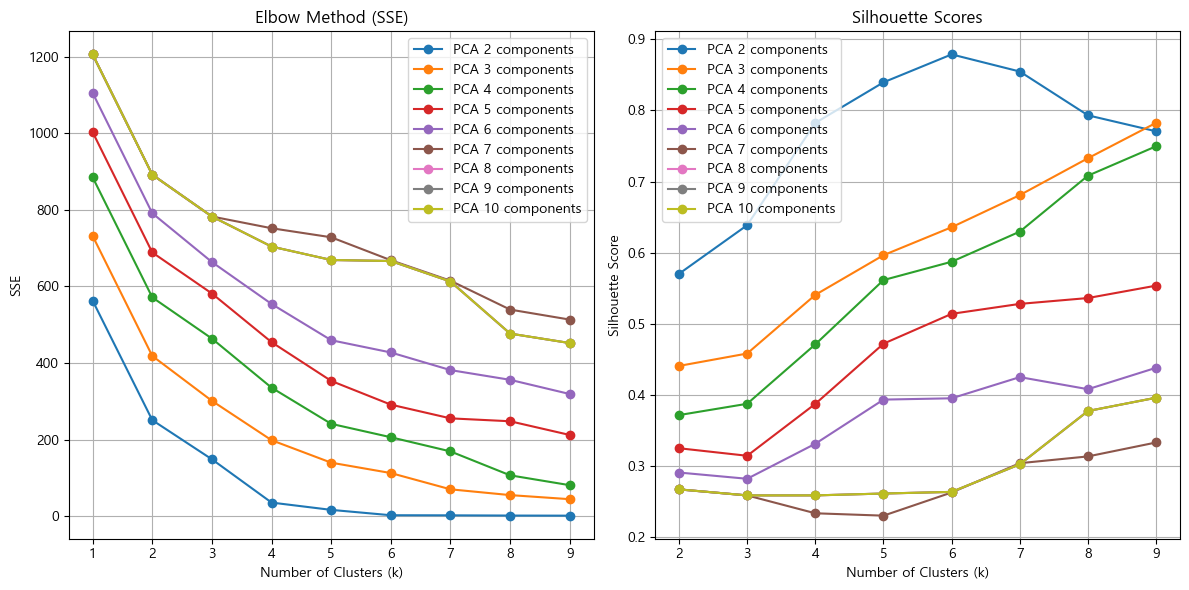

In [9]:
# 결과를 시각화
plt.figure(figsize=(12, 6))

# SSE 그래프
plt.subplot(1, 2, 1)
for n_components in components_range:
    plt.plot(range(1, 10), results[n_components]["SSE"], marker='o', label=f'PCA {n_components} components')
plt.title('Elbow Method (SSE)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE')
plt.legend()
plt.grid()

# 실루엣 점수 그래프
plt.subplot(1, 2, 2)
for n_components in components_range:
    plt.plot(range(2, 10), results[n_components]["Silhouette Scores"][1:], marker='o', label=f'PCA {n_components} components')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# 주성분 개수 2개, 클러스터 개수 4개로 결정함(KNN이 완만해지는 지점 + 실루엣 계수가 돌파하는 지점 )

# pca(2) -> kmeans(4)

실루엣 점수: 0.78


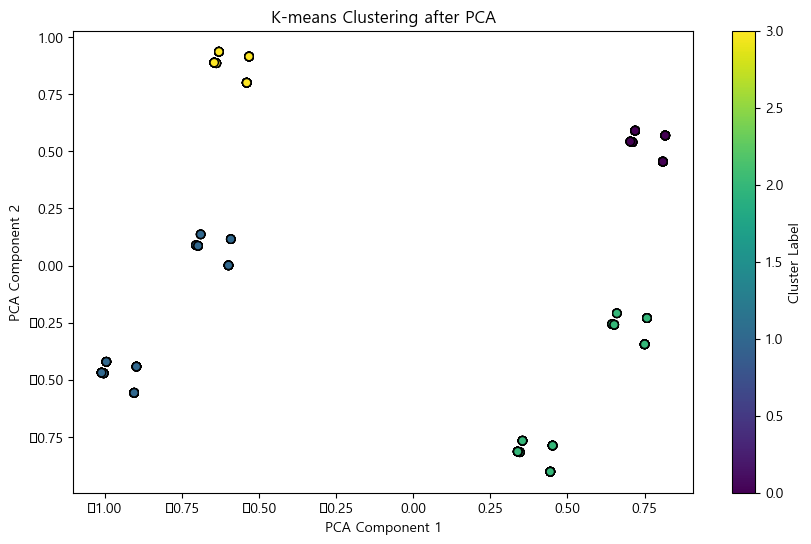

In [12]:
# 데이터프레임에서 필요한 컬럼 선택 및 스케일링
X=np.array(df_encoded.dropna())

# PCA를 사용하여 2차원으로 차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# K-means 클러스터링 수행
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_pca)

# 클러스터 레이블을 데이터프레임에 추가
inpo_df['kmeans_cluster'] = kmeans.labels_

# 실루엣 점수 계산
silhouette_avg = silhouette_score(X_pca, kmeans.labels_)
print(f'실루엣 점수: {silhouette_avg:.2f}')

# K-means 클러스터링 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', marker='o', edgecolor='k')
plt.title('K-means Clustering after PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


In [15]:
k_df = inpo_df

# EDA clustered by Kmeans

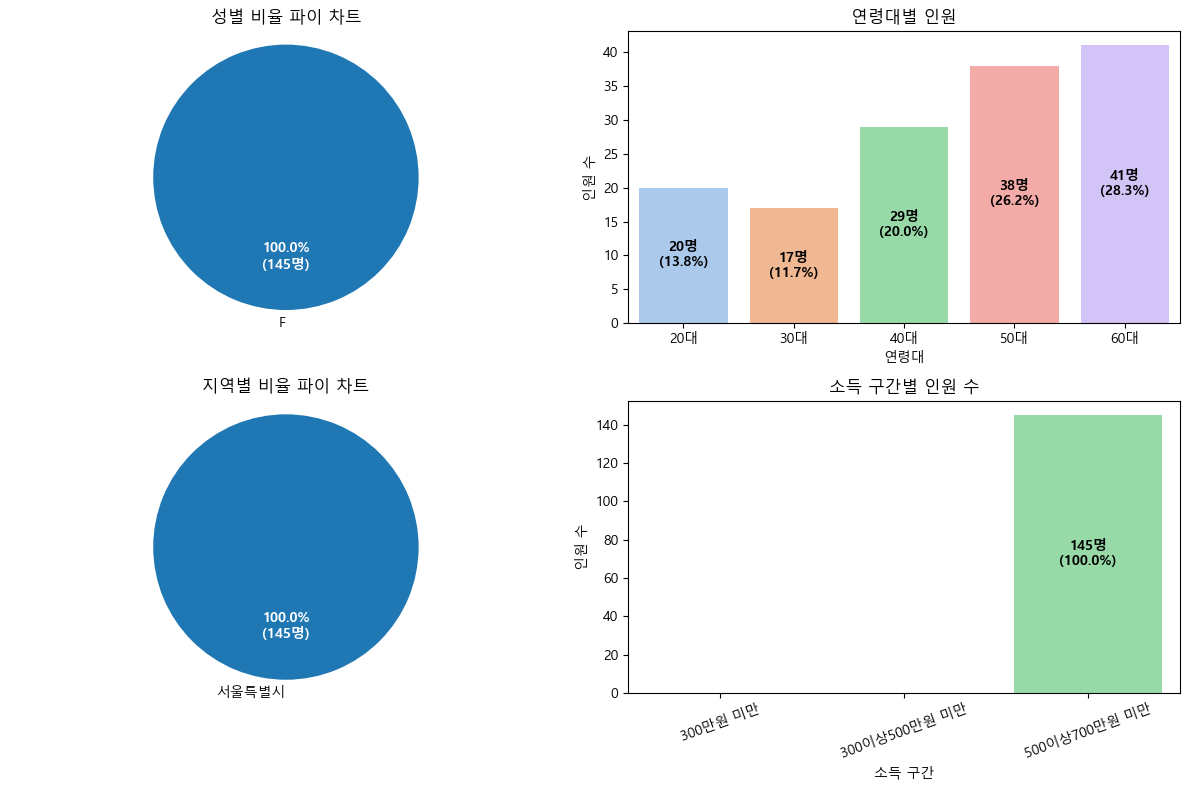

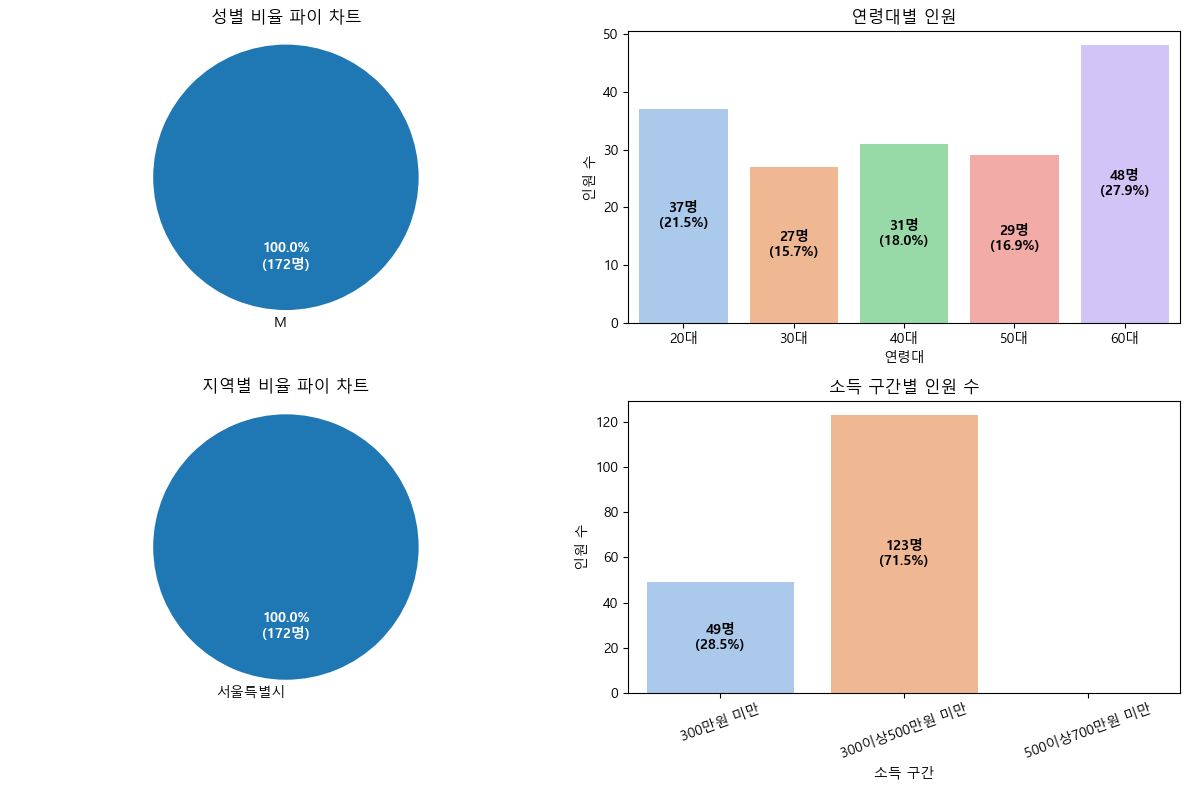

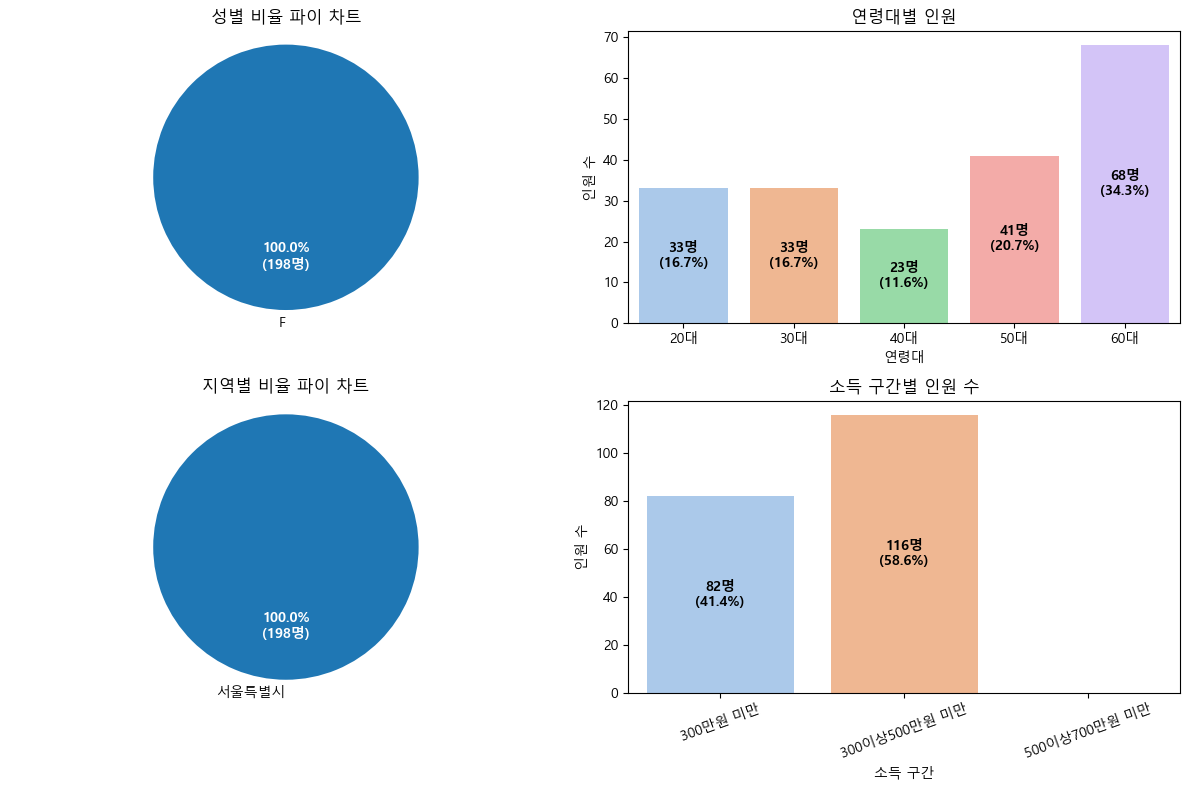

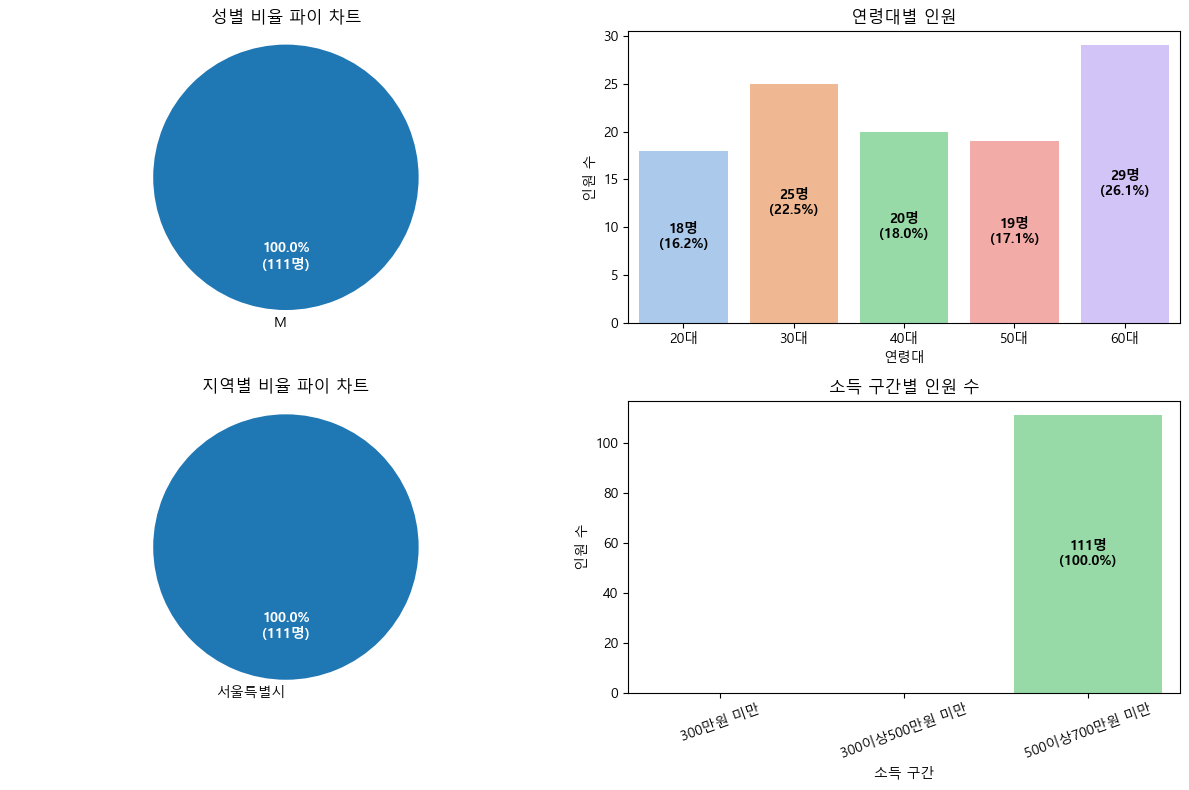

In [16]:
def autopct_format(pct, allvals):
    num = int(round(pct * np.sum(allvals) / 100.0))
    return f'{pct:.1f}%\n({num}명)'

for cluster_num in [0, 1, 2, 3]:
    grouped_df = k_df[k_df['kmeans_cluster'] == cluster_num]

    sex_counts = grouped_df['SEX'].value_counts()
    sex_labels = sex_counts.index
    sex_sizes = sex_counts.values

    age_counts = grouped_df['AGE'].value_counts().sort_index()
    age_labels = age_counts.index
    age_sizes = age_counts.values

    area_counts = grouped_df['AREA'].value_counts()
    area_labels = area_counts.index
    area_sizes = area_counts.values

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # [0, 0] 성별 파이 차트 (비율+개수)
    wedges, texts, autotexts = axs[0, 0].pie(
        sex_sizes, labels=sex_labels,
        autopct=lambda pct: autopct_format(pct, sex_sizes), startangle=90)
    axs[0, 0].axis('equal')
    axs[0, 0].set_title("성별 비율 파이 차트")
    plt.setp(autotexts, size=10, weight="bold", color="white")

    # [0, 1] 연령대 Barplot (중앙에 표시)
    bars = sns.barplot(x=age_labels, y=age_sizes, ax=axs[0, 1], palette='pastel')
    axs[0, 1].set_title("연령대별 인원")
    axs[0, 1].set_ylabel("인원 수")
    axs[0, 1].set_xlabel("연령대")
    total = np.sum(age_sizes)
    for bar in bars.patches:
        height = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2
        y = height / 2    # ▶️ 중앙에 출력
        pct = 100 * height / total if total else 0
        axs[0, 1].text(x, y, f'{int(height)}명\n({pct:.1f}%)',
                       ha='center', va='center', fontsize=10, fontweight='bold')

    # [1, 0] 지역 파이 차트 (비율+개수)
    wedges, texts, autotexts = axs[1, 0].pie(
        area_sizes, labels=area_labels,
        autopct=lambda pct: autopct_format(pct, area_sizes), startangle=90)
    axs[1, 0].axis('equal')
    axs[1, 0].set_title("지역별 비율 파이 차트")
    plt.setp(autotexts, size=10, weight="bold", color="white")

    # [1, 1] 소득 Countplot (중앙에 표시)
    income_order = ['300만원 미만', '300이상500만원 미만', '500이상700만원 미만']
    countplot = sns.countplot(x='INCOME', data=grouped_df, ax=axs[1, 1], palette='pastel', order=income_order)
    axs[1, 1].set_title("소득 구간별 인원 수")
    axs[1, 1].set_xlabel("소득 구간")
    axs[1, 1].set_ylabel("인원 수")
    axs[1, 1].tick_params(axis='x', rotation=20)
    total_income = len(grouped_df)
    for p in countplot.patches:
        height = p.get_height()
        x = p.get_x() + p.get_width() / 2
        y = height / 2    # ▶️ 중앙에 출력
        pct = 100 * height / total_income if total_income else 0
        axs[1, 1].text(x, y, f'{int(height)}명\n({pct:.1f}%)',
                       ha='center', va='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()


# kmeans 클러스터 df 저장

In [17]:
k_df.to_csv('preprocessed data/k_df.csv')